In [1]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
import functions
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline

TRAIN_DIR = "train"
TEST_DIR = "test"

In [2]:
def predictAccuracy(y1, y2, cutoff = .5):
    return sum([a == (b >= cutoff) for a,b in zip(y1,y2)]) / float(len(y1))

def cv_optimize(clf, parameters, X, y, n_jobs, n_folds, score_func, verbose):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, verbose=verbose, scoring=score_func)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best, gs.best_params_

def do_classify(clf, parameters, X, y, mask=None, n_folds=5, n_jobs=4, verbose=False, score_func=None):
    if mask is None:
        print "Test"
        mask = functions.split_mask(X)
    X_train, X_cv, y_train, y_cv = X[mask], X[~mask], y[mask], y[~mask]
    clf, best_params_ = cv_optimize(clf, parameters, X_train, y_train, n_jobs=n_jobs, n_folds=n_folds, verbose=verbose, score_func=score_func)
    clf=clf.fit(X_train, y_train)
    train_preds = clf.predict(X_train)
    cv_preds = clf.predict(X_cv)
    training_accuracy = predictAccuracy(y_train, train_preds, .5)
    cv_accuracy = predictAccuracy(y_cv, cv_preds)
    if verbose:
        print "Training classes"
        print training_accuracy
        print "############# based on standard predict ################"
        print "Accuracy on training data: %0.4f" % training_accuracy
        print "Accuracy on crossv data:   %0.4f" % cv_accuracy
        print "########################################################"
    return clf, X_train, y_train, X_cv, y_cv, best_params_

In [3]:
X, y, ids, call_list = functions.create_data_matrix(direc=TRAIN_DIR, verbose=True)

Number of datafiles loaded: 3086


In [4]:
classes = ['Agent','autorun','fraudload','fraudpack','hupigon','krap','lipler','magania','None','poison','swizzor','tdss','vb','virut','zbot']

In [5]:
counter = Counter(y)

for i, v in enumerate(classes):
    print counter[i], v

114 Agent
50 autorun
37 fraudload
32 fraudpack
41 hupigon
39 krap
53 lipler
41 magania
1609 None
21 poison
542 swizzor
32 tdss
376 vb
59 virut
40 zbot


In [6]:
bad_words = ['money','.exe','.sys','msvbvm60','hklm','1054','local.ds','8.tmp','wscsvc','settings','.doc','.php','ip6','fgs','sv.exe',
            'sex.','.html','.int','.net','mem','mmc.exe','graypigeon','hacker','gray','favorit-network','.rar','.ru','.pl',
            'porn','virus','anti','game','ayb','lsass.exe','christian']

In [7]:
results = []
for i, datafile in enumerate(os.listdir("train")):
    if datafile == '.DS_Store':
        continue
    counts = []
    print "\rNumber of datafiles loaded:", i,
    for word in bad_words:
        counts.append(len(str.lower(open("train/"+datafile).read()).split(word))-1)
    results.append(counts)

Number of datafiles loaded: 3086


In [8]:
X_new = np.hstack((X, np.array(results)))

In [9]:
X_new.shape

(3086L, 141L)

In [10]:
X_ = pd.DataFrame(X_new, columns = call_list+bad_words)
X_.shape

(3086, 141)

In [11]:
mask = functions.split_mask(X_, .99)

In [12]:
y_morphed = np.array([0 if y_ == 8 else 1 for y_ in y])

In [13]:
y_lists = []
for y_ in range(15):
    y_lists.append(np.array([1 if y__ == y_ else 0 for y__ in y]))

In [14]:
clfForest = RandomForestClassifier()
clfForestRegressor = RandomForestRegressor()
parameters = {
#    "n_estimators" : [100],
    "n_estimators" : [5,10,20,40,80,160,320,640],
#    "max_depth": [25]
    "max_depth": [50,100,200,400,None]
}

In [15]:
%%time
forests = []
for lst in y_lists:
    clfForest_test, _, _, X_cv, y_cv, best_params = do_classify(clfForestRegressor, {}, X_, lst, mask=mask, n_folds = 3, n_jobs = 1, score_func="roc_auc", verbose=False)
    forests.append(clfForest_test)

BEST {} 0.822900969855 [mean: 0.82290, std: 0.03380, params: {}]
BEST {} 0.86536020377 [mean: 0.86536, std: 0.07575, params: {}]
BEST {} 0.883676921776 [mean: 0.88368, std: 0.05579, params: {}]
BEST {} 0.943494819223 [mean: 0.94349, std: 0.04800, params: {}]
BEST {} 0.879692813035 [mean: 0.87969, std: 0.03281, params: {}]
BEST {} 0.876099050944 [mean: 0.87610, std: 0.03317, params: {}]
BEST {} 0.991590633021 [mean: 0.99159, std: 0.01182, params: {}]
BEST {} 0.917801456763 [mean: 0.91780, std: 0.05805, params: {}]
BEST {} 0.973081816187 [mean: 0.97308, std: 0.00474, params: {}]
BEST {} 0.836714626387 [mean: 0.83671, std: 0.11455, params: {}]
BEST {} 0.996707059864 [mean: 0.99671, std: 0.00195, params: {}]
BEST {} 0.908620933056 [mean: 0.90862, std: 0.05776, params: {}]
BEST {} 0.987753310132 [mean: 0.98775, std: 0.00212, params: {}]
BEST {} 0.784139906212 [mean: 0.78414, std: 0.02208, params: {}]
BEST {} 0.971252321523 [mean: 0.97125, std: 0.01932, params: {}]
Wall time: 17.1 s


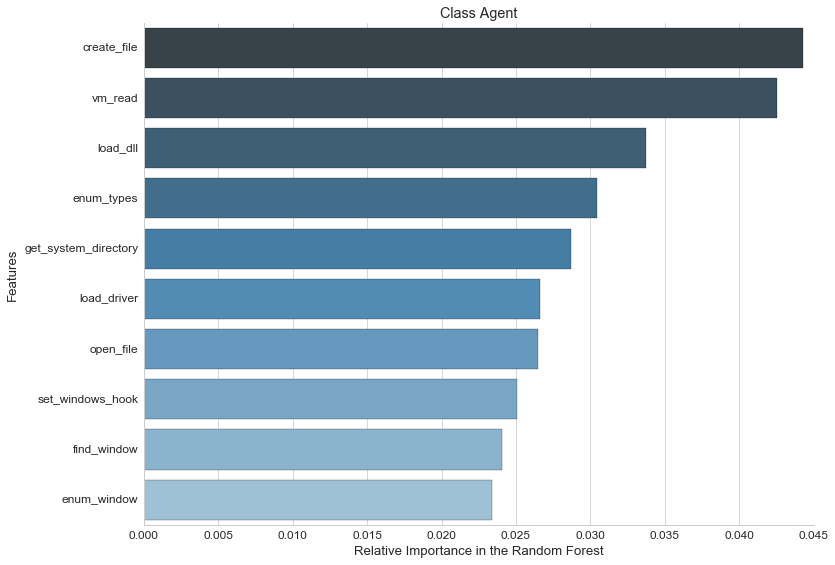

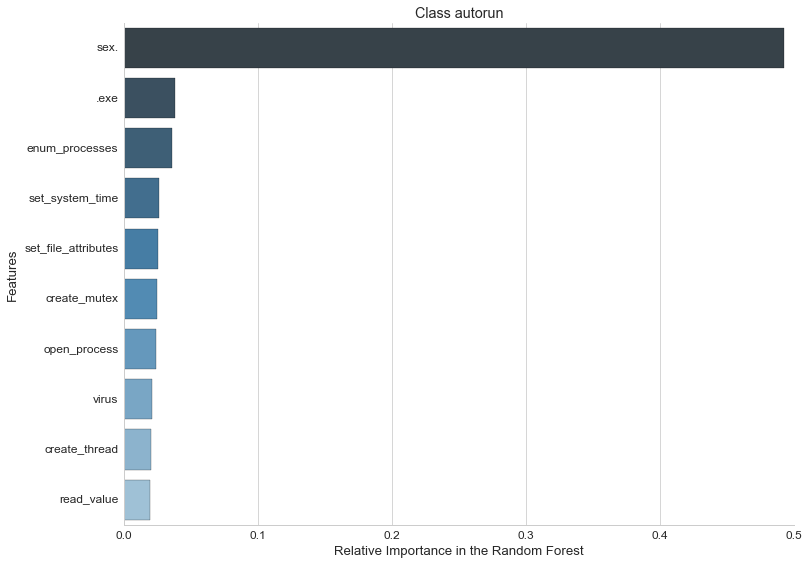

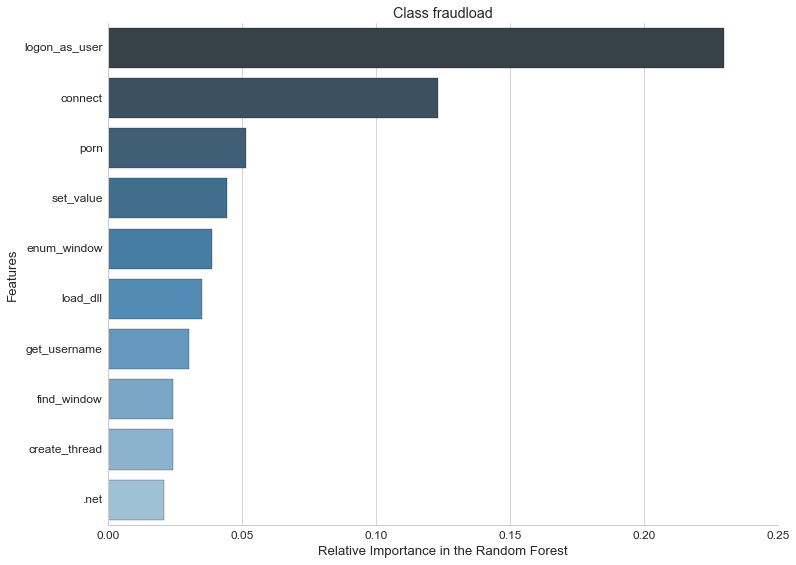

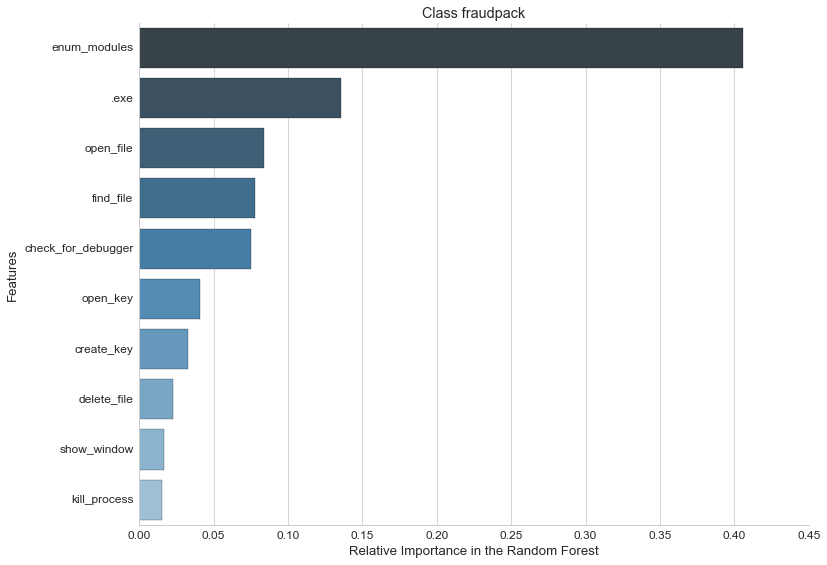

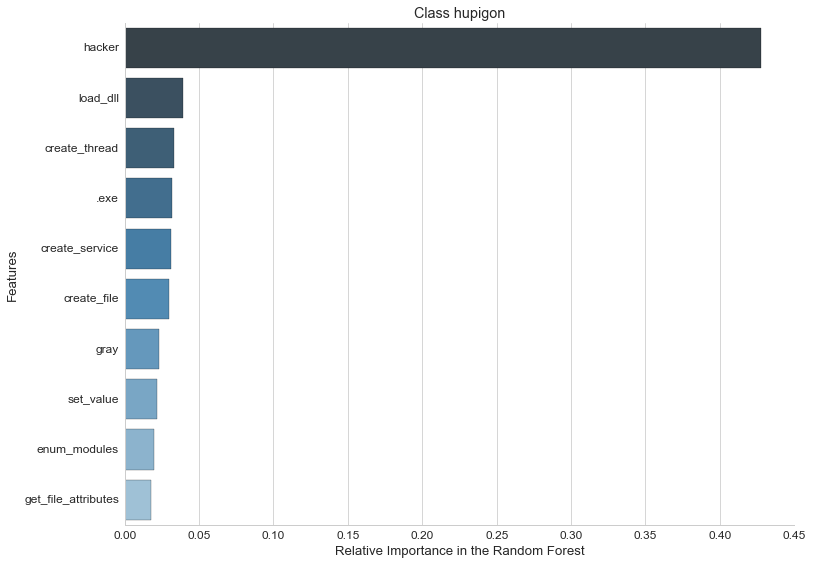

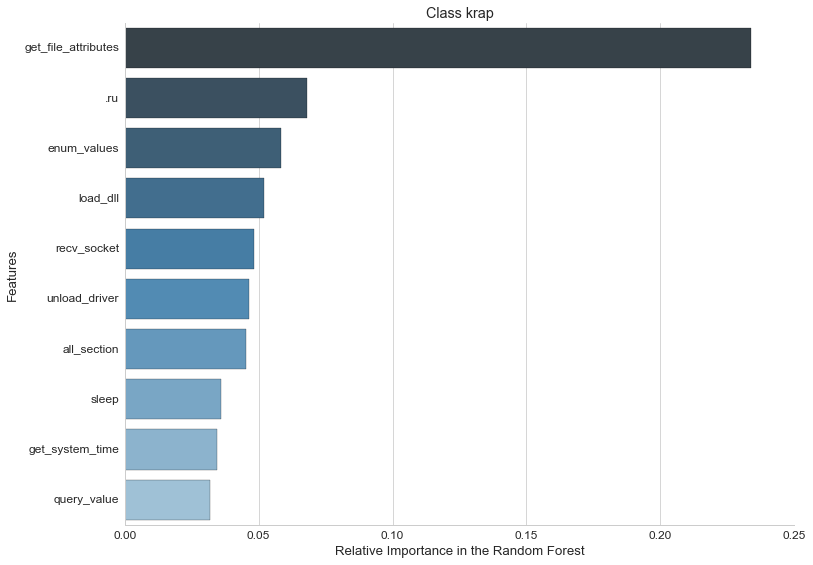

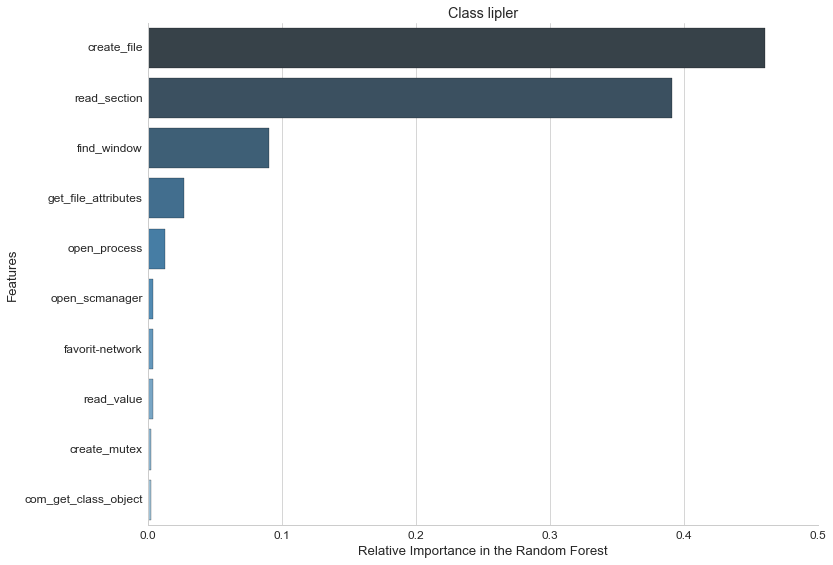

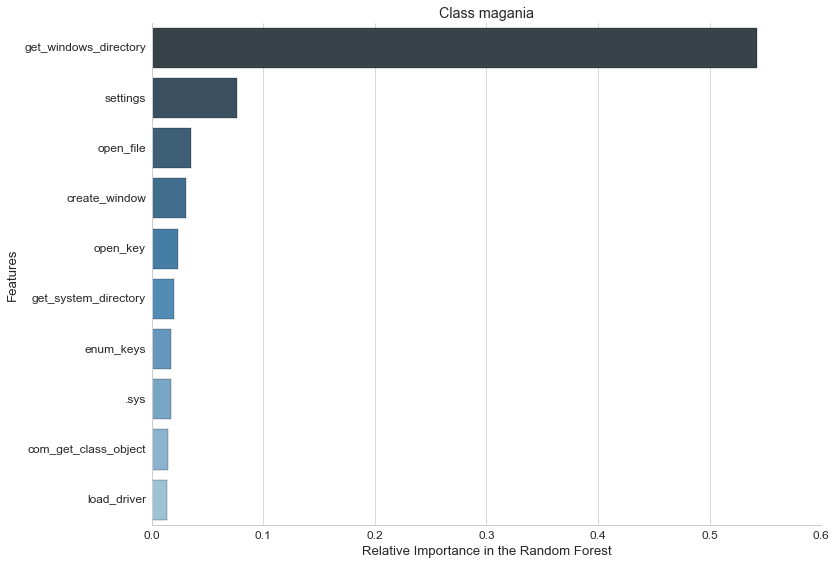

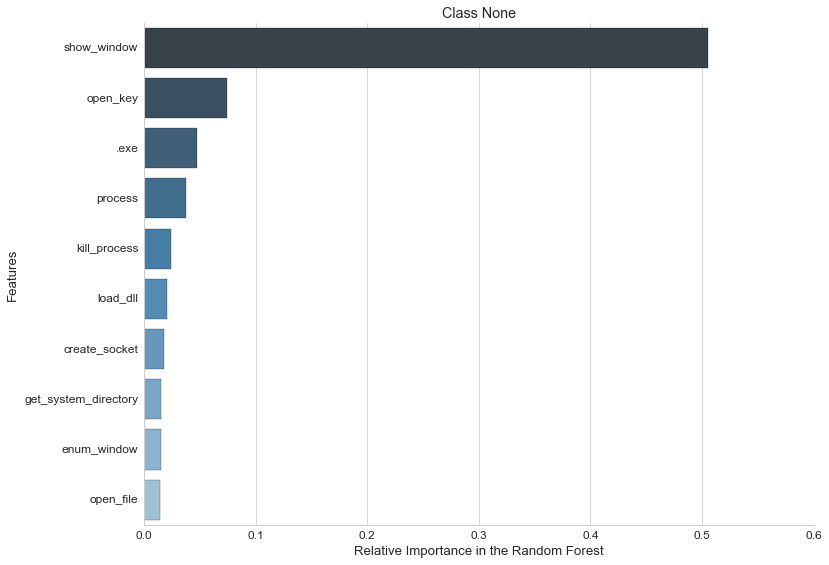

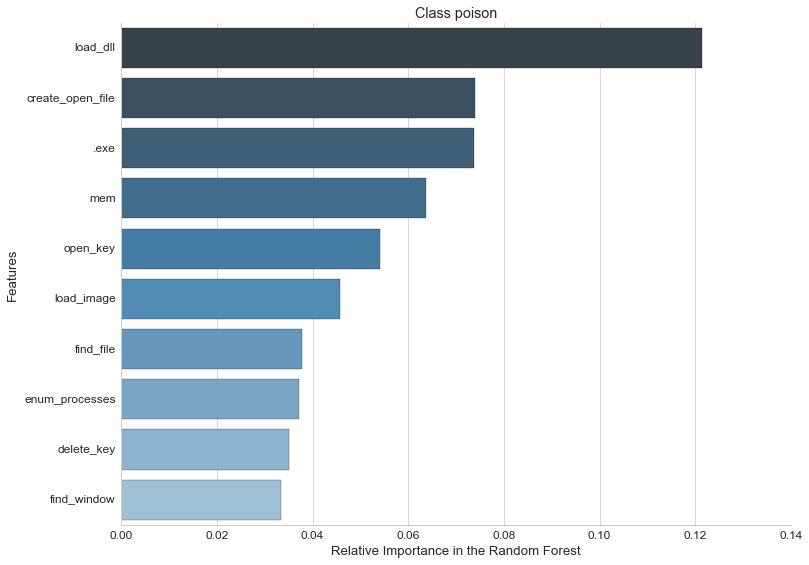

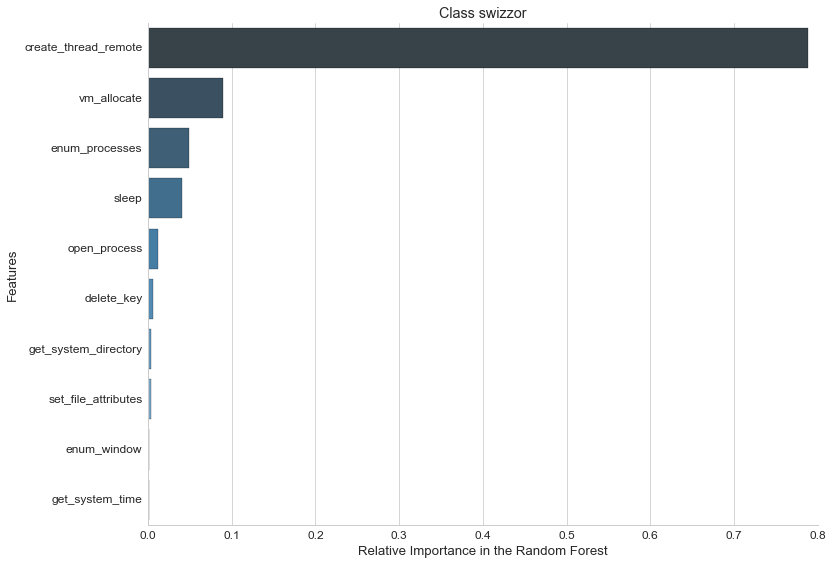

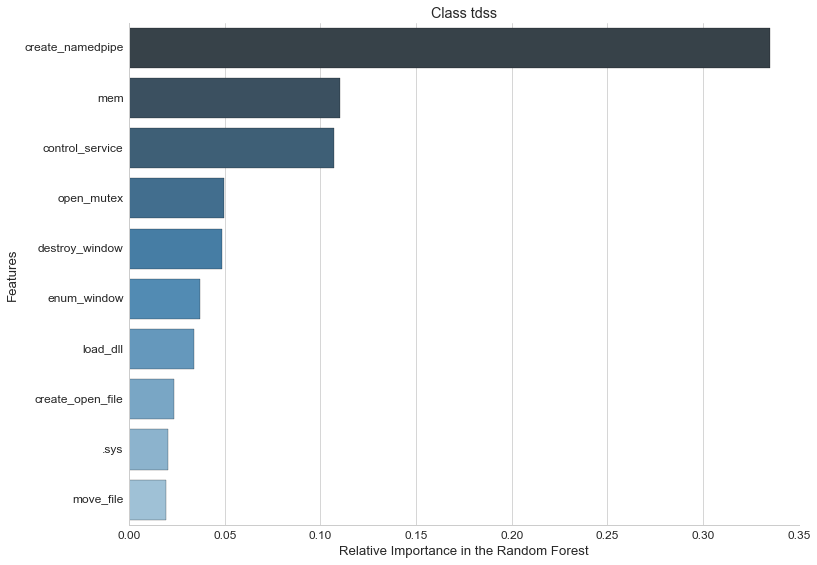

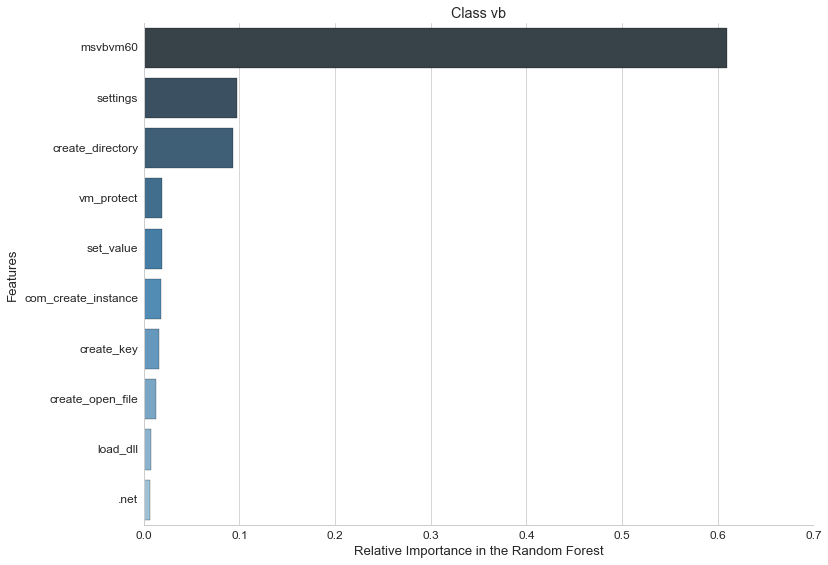

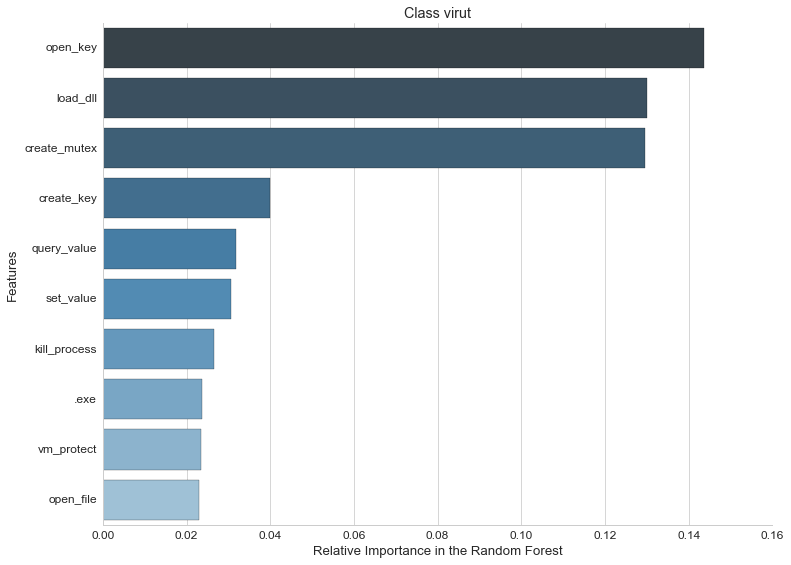

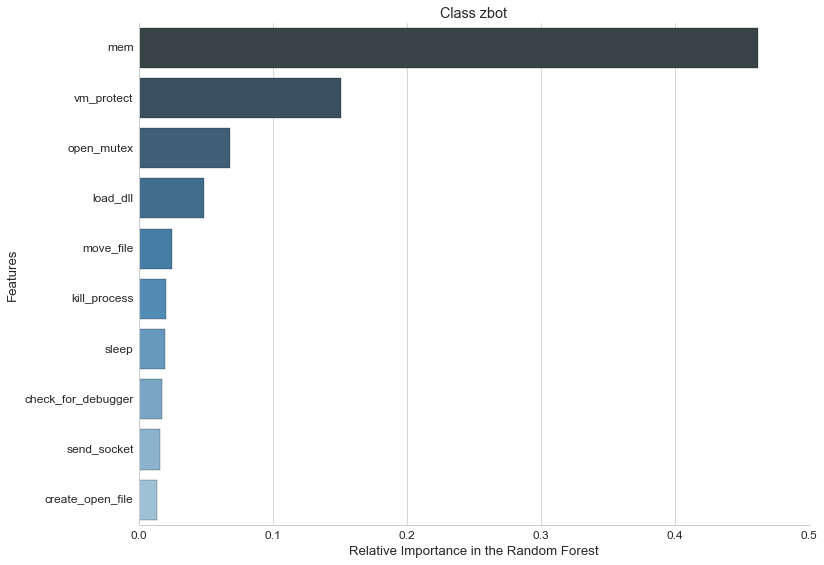

In [16]:
for f,c in zip(forests, classes):
    importance_list = f.feature_importances_
    importance_list, name_list = zip(*sorted(zip(importance_list, X_.columns)))
    sns.set_context("paper", font_scale=1.5)
    plt.figure(figsize=(12, 9))
    ax = sns.barplot(y=range(10),x=list(reversed(importance_list))[:10], orient='h', palette="Blues_d")
    ax.set_xlabel('Relative Importance in the Random Forest')
    ax.set_ylabel('Features')
    ax.set_title('Class %s' % c)
    ax.set_yticklabels(list(reversed(name_list)));
    sns.despine()
    plt.savefig('Baseline Relative Importance %s.png' % c, bbox_inches='tight')

In [99]:
#X_cv, y_cv = X[~mask], y[~mask]

In [17]:
def predict(preds):
    return np.array([np.argmax(p) for p in zip(*np.array(preds))])

def accuracy(preds, actual):
    return sum([a == b for a,b in zip(preds, actual)]) / float(len(preds))    

In [102]:
#preds_mat = [f.predict(X_cv) for f in forests]

In [103]:
#preds = predict(preds_mat)

In [104]:
#accuracy(preds, y_cv)

In [18]:
X_test, y_test, ids, _ = functions.create_data_matrix(direc=TEST_DIR, verbose=True, call_list=call_list)

Number of datafiles loaded: 3724


In [19]:
results = []
for i, datafile in enumerate(os.listdir("test")):
    if datafile == '.DS_Store':
        continue
    counts = []
    print "\rNumber of datafiles loaded:", i,
    for word in bad_words:
        counts.append(len(str.lower(open("test/"+datafile).read()).split(word))-1)
    results.append(counts)

Number of datafiles loaded: 3723


In [20]:
X_test_ = pd.DataFrame(np.hstack((X_test, np.array(results))), columns = call_list+bad_words)

In [21]:
print X_test_.shape

(3724, 141)


In [22]:
preds_mat_act = [f.predict(X_test_) for f in forests]

In [23]:
preds_act = predict(preds_mat_act)

In [71]:
# We have predictions!!!!

In [ ]:
functions.write_to_file("submissions/RandForest_mult_8.csv", ids, preds_act)